In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import least_squares
from scipy.signal import convolve2d

In [2]:
def median(arr, mask):     
    fl_arr = arr.flatten()
    fl_mask = mask.flatten()
    
    N = len(fl_arr)
    data = []
    
    for i in range(N):
        if fl_mask[i]:
            data.append(fl_arr[i])
            
    #print(data)
    
    return np.median(data)

def gen_xy(width, height):
    x = np.linspace(0, width, num=width)-width/2
    y = np.linspace(0, height, num=height)-height/2
    return np.meshgrid(x, y)

def profile(params, width, height):
    x0, y0, bkg, ampl, sigma2 = params
    
    x = np.linspace(0, width, num=width) - x0
    y = np.linspace(0, height, num=height) - y0
    
    x,y = np.meshgrid(x, y)
    
    return bkg + ampl*np.exp(-(x**2+y**2)/2/sigma2)

def profile3d(params, width, height, depth):
    x0, y0, z0, bkg, ampl, sigma2 = params
    
    x = np.linspace(0, width, num=width) - x0
    y = np.linspace(0, height, num=height) - y0
    z = np.linspace(0, height, num=depth) - z0
    
    x, y, z = np.meshgrid(x, y, z)
    
    return bkg + ampl*np.exp(-(x**2+y**2+z**2)/2/sigma2)

def generate(width, height, bkg, ampl, sigma, scale=1.0):
    x = np.linspace(0, width, num=width) - width/2
    y = np.linspace(0, height, num=height) - height/2
    x, y = np.meshgrid(x, y)
    
    exact = profile([width/2, height/2, bkg, ampl, sigma], width, height)
    noise = np.random.normal(size=(height, width))
    noise *= np.sqrt(exact)*scale
    
    noise += exact
    noise *= (noise > 0)
    
    return exact, noise

def generate3d(width, height, depth, bkg, ampl, sigma, scale=1.0):
    x = np.linspace(0, width, num=width) - width/2
    y = np.linspace(0, height, num=height) - height/2
    z = np.linspace(0, depth, num=depth) - depth/2
    x, y, z = np.meshgrid(x, y, z)
    
    exact = profile3d([width/2, height/2, depth/2, bkg, ampl, sigma], width, height, depth)
    print(exact.shape)
    noise = np.random.normal(size=(height, width, depth))
    noise *= np.sqrt(exact)*scale
    
    noise += exact
    noise *= (noise > 0)
    
    return exact, noise

In [3]:
def correlation(im1, im2):
    fl1 = im1.flatten()
    fl2 = im2.flatten()
    
    fl1 -= fl1.mean()
    fl2 -= fl2.mean()
    
    return (fl1*fl2).sum() / np.sqrt((fl1**2).sum() * (fl2**2).sum())

In [4]:
def initial_guess(im):
    mean = im.mean()
    std = im.std()
    
    bkg = (im <= mean+std)    
    bkg = (bkg*im).sum() / bkg.sum()
    
    
    scaled = im / bkg
    
    height, width = im.shape
    
    x = np.array(range(width))
    y = np.array(range(height))
    
    x0 = (x*scaled).sum() / scaled.sum()
    y0 = (y*scaled).sum() / scaled.sum()
    
    ampl = im.max() - bkg
    
    c_xx = ((x-x0)**2*scaled).sum() / scaled.sum()
    c_yy = ((y-y0)**2*scaled).sum() / scaled.sum()
    c_xy = ((x-x0)*(y-y0)*scaled).sum() / scaled.sum()
    
    cov = np.array([[c_xx, c_xy], [c_xy, c_yy]])
    
    w,v = np.linalg.eig(cov)
    
    sigma2 = 0.5*w.sum()
    
    return [x0, y0, bkg, ampl, sigma2]

def profile(params, width, height):
    x0, y0, bkg, ampl, sigma2 = params
    
    x = np.linspace(0, width, num=width) - x0
    y = np.linspace(0, height, num=height) - y0
    
    x,y = np.meshgrid(x, y)
    
    return bkg + ampl*np.exp(-(x**2+y**2)/2/sigma2)

In [5]:
scale = 5.0
exact, noise = generate(30, 30, 400, 200, 2, scale)

def residual(params, reference):
    height, width = reference.shape
    predict = profile(params, width, height)
    
    delta = (reference - predict)
    #delta /= scale*np.sqrt(reference)
    
    return delta.flatten()

def integrate(data, x0, y0, r1, r2, r3):
    height, width = data.shape
    x = np.linspace(0, width, num=width) - x0
    y = np.linspace(0, height, num=height) - y0
    x, y = np.meshgrid(x,y)
    
    rr = x**2+y**2
    
    peak = rr < r1**2
    #bkg = (rr > r2**2) * (rr < r3**2)
    bkg = (rr>r2**2)*(np.abs(x)<r3)*(np.abs(y)<r3)
    
    mean_bkg = (data*bkg).sum() / bkg.sum()
    return ((data-mean_bkg)*peak).sum()

def integrate_iter(data, x0, y0, r1, r2, r3, niter):
    height, width = data.shape
    x = np.linspace(0, width, num=width) - x0
    y = np.linspace(0, height, num=height) - y0
    x, y = np.meshgrid(x,y)
    
    rr = x**2+y**2
    
    peak = rr < r1**2
    #bkg = (rr > r2**2) * (rr < r3**2)
    bkg_mask =(rr>r2**2)*(np.abs(x)<r3)*(np.abs(y)<r3)    
    mean_bkg = (data*bkg_mask).sum() / bkg_mask.sum()
    
    for _ in range(niter):
        std_bkg = np.sqrt(((data-mean_bkg)**2 * bkg_mask).sum() / (bkg_mask.sum()-1))
        bkg_mask *= (np.abs(data-mean_bkg) > 2*std_bkg)
        mean_bkg = (data*bkg_mask).sum() / bkg_mask.sum()
    
    return ((data-mean_bkg)*peak).sum()


def integrate_median(data, x0, y0, r1, r2, r3):
    height, width = data.shape
    x = np.linspace(0, width, num=width) - x0
    y = np.linspace(0, height, num=height) - y0
    x, y = np.meshgrid(x,y)
    
    rr = x**2+y**2
    
    peak = rr < r1**2
    bkg_mask =(rr>r2**2)*(np.abs(x)<r3)*(np.abs(y)<r3)    
    median_bkg = median(data, bkg_mask)
    
    return ((data-median_bkg)*peak).sum()

In [6]:
initial_guess(exact)

[14.5, 14.5, 400.16503603336434, 174.79333123775223, 74.44321694150796]

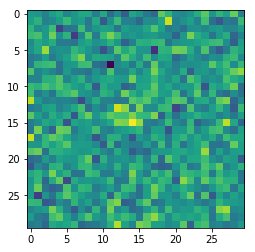

In [7]:
plt.imshow(noise)
plt.show()

2348.515041483569 5211.902331202335 5211.902331202304
0.183371058268259 0.19980992123691166
exact 2348.5074432202427
noise 2628.4640843689576
noise iter 1 -4152.349683506898
noise median 3041.896707012813
noise conv 3092.7401200881436


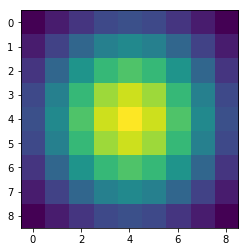

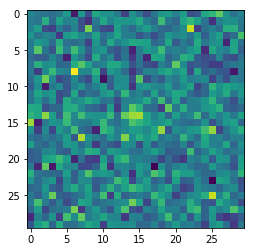

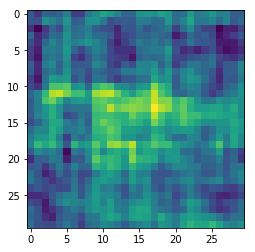

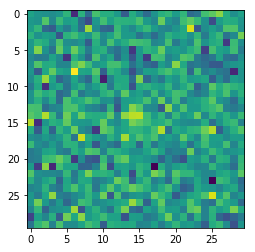

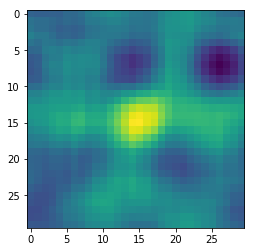

0.24035184762686482
0.4953909754021386


In [8]:
kwidth = 9
kheight = 9

width = 30
height = 30

scale = 5.0
bkg = 400
ampl = 200

sigma = 2

exact, noise = generate(width, height, bkg, ampl, sigma, scale)

kernel = profile([kwidth/2, kheight/2, 0, 1, 9], kwidth, kheight)

delta_kernel = 0*kernel
delta_kernel[0,0] = 1.0

kernel /= kernel.sum()

shift_kernel = np.roll(kernel, -round(kwidth/2), axis=0)
shift_kernel = np.roll(shift_kernel, -round(kheight/2), axis=1)

noise_conv = convolve2d(noise, shift_kernel, mode='same', boundary='wrap')
exact_conv = convolve2d(exact, delta_kernel, mode='same', boundary='wrap')

print((exact-bkg).sum(), (noise-bkg).sum(), (noise_conv-bkg).sum())
print(correlation(exact, noise), correlation(exact_conv, noise_conv))

r1 = 3.5*sigma
r2 = 5*sigma
r3 = 7*sigma

print('exact', integrate(exact, width/2, height/2, r1, r2, r3))
print('noise', integrate(noise, width/2, height/2, r1, r2, r3))
print('noise iter 1', integrate_iter(noise, width/2, height/2, r1, r2, r3, 1))
print('noise median', integrate_median(noise, width/2, height/2, r1, r2, r3))
print('noise conv', integrate(noise_conv, width/2, height/2, r1, r2, r3))

plt.imshow(kernel)
plt.show()

plt.imshow(noise)
plt.show()

plt.imshow(noise_conv)
plt.show()

anscombe_conv = scale*convolve2d(np.sqrt(noise/scale), kernel, mode='same', boundary='wrap')**2

plt.imshow(np.sqrt(noise/scale))
plt.show()

plt.imshow(anscombe_conv)
plt.show()

print(correlation(exact, noise_conv))
print(correlation(exact, anscombe_conv))

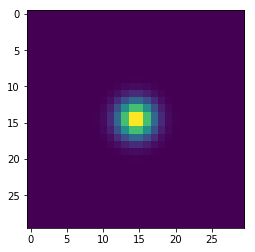

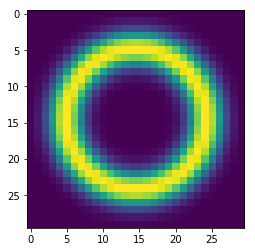

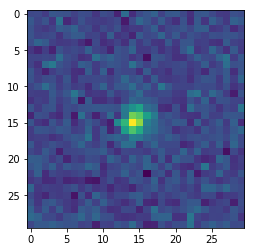

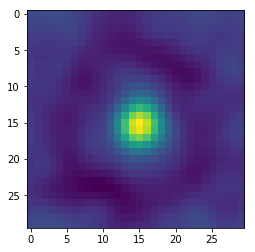

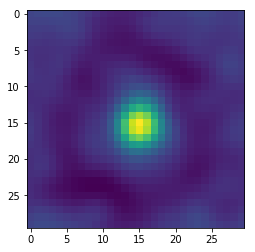

0.8153728769655271
2.092048851299648


In [19]:
def kernels(width, height, r0, sigma):
    x, y = gen_xy(width, height)
    rr = x**2+y**2
    kernel1 = np.exp(-0.5*rr/sigma)
    kernel2 = np.exp(-0.5*(np.sqrt(rr)-r0)**2/sigma)  
    kernel1 /= kernel1.sum()
    kernel2 /= kernel2.sum()
    return kernel1, kernel2

k1, k2 = kernels(30, 30, 10, 3)

plt.imshow(k1)
plt.show()

plt.imshow(k2)
plt.show()

exact, noise = generate(30, 30, 400, 1000, 2, 5.0)

plt.imshow(noise)
plt.show()

c1 = convolve2d(noise, k1, mode='same', boundary='wrap')
c2 = convolve2d(noise, k2, mode='same', boundary='wrap')

plt.imshow(c1-c2)
plt.show()

plt.imshow(c1/c2)
plt.show()

print((c1/c2).min())
print((c1/c2).max())

In [22]:
#result = least_squares(residual, initial_guess(noise))

fit_height, fit_width = noise.shape

p0 = initial_guess(anscombe_conv)
result_anscombe = least_squares(lambda p: residual(p, anscombe_conv), p0)
result_noise = least_squares(lambda p: residual(p, noise), result_anscombe.x)

print(correlation(noise, profile(result_noise.x, fit_height, fit_width)))
x0, y0, fit_bkg, fit_ampl, fit_sigma = result_noise.x
print(result_noise.x)

exact_int = (exact-bkg).sum()
noise_int = integrate(noise, x0, y0, 3*fit_sigma, 5*fit_sigma, 6*fit_sigma)
profile_int = (profile(result_noise.x, fit_height, fit_width)-fit_bkg).sum()

print(exact_int)
print(noise_int)
print(profile_int)
print(0.5*(profile_int+noise_int))

0.07164039600718627
[ 16.31691534  14.32239717 393.8805573   80.98922003   5.02951387]
1174.2575207417844
nan
2391.5891858168434
nan


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


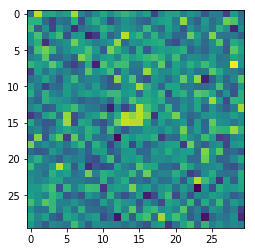

In [11]:
plt.imshow(noise)
plt.show()

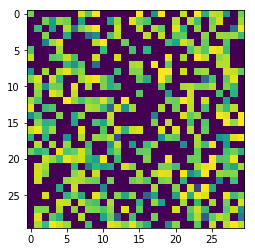

mean bkg 317.54206514484144


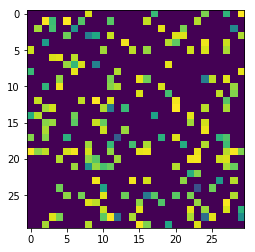

mean bkg 260.45157203715837


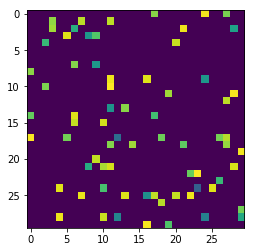

mean bkg 209.84801648177498


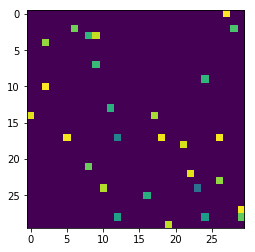

mean bkg 165.64749140298878


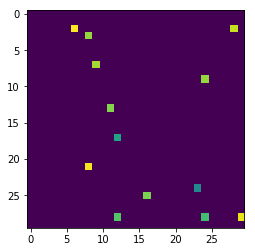

mean bkg 132.06990064177404


In [12]:
niter = 5

avg_bkg = noise.mean()

for _ in range(niter):
    low = (noise < avg_bkg)
    avg_bkg = (low*noise).sum() / low.sum()
    
    plt.imshow(low*noise)
    plt.show()
    
    
    print('mean bkg', avg_bkg)

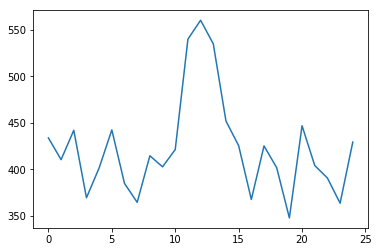

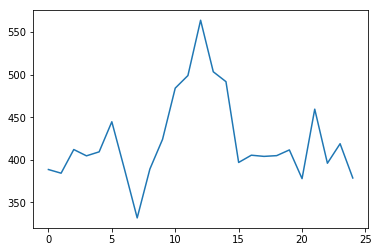

In [13]:
exact, noise = generate(25, 25, 400, 1000, 2, 7)

plt.plot(np.mean(noise, axis=0))
plt.show()

plt.plot(np.mean(noise, axis=1))
plt.show()

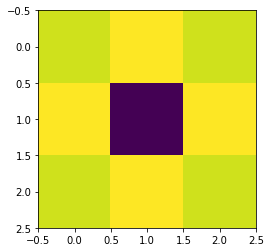

In [14]:
laplace = np.array([[0.25, 0.5, 0.25], [0.5, -3, 0.5], [0.25, 0.5, 0.25]])

plt.imshow(laplace)
plt.show()

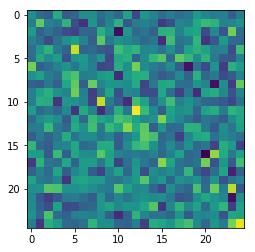

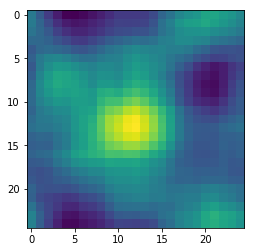

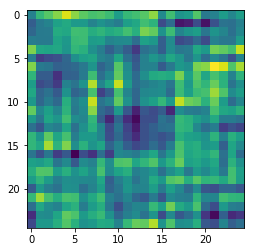

In [15]:
exact, noise = generate(25, 25, 400, 200, 2, 7)

noise_conv = convolve2d(noise, kernel, mode='same', boundary='wrap')

conv_laplace = convolve2d(noise_conv, laplace, mode='same', boundary='wrap')

plt.imshow(noise)
plt.show()

plt.imshow(noise_conv)
plt.show()

plt.imshow(conv_laplace)
plt.show()

(30, 30, 30)


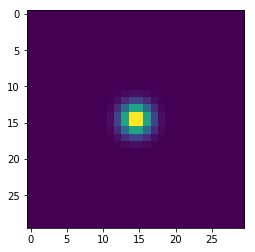

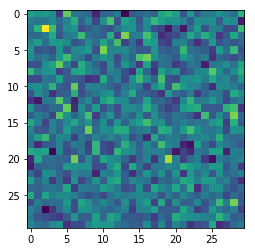

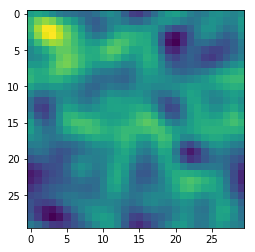

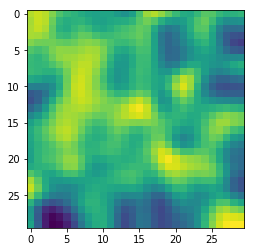

In [16]:
from scipy.ndimage.filters import convolve

kernel = profile([5, 5, 0, 1, 3], 10, 10)
kernel3d = profile3d([5, 5, 5, 0, 1, 3], 10, 10, 10)

kernel /= kernel.sum()
kernel3d /= kernel3d.sum()

z0 = 16

exact, noise = generate3d(30, 30, 30, 400, 200, 2, 7.0)

conv = convolve2d(noise[z0], kernel, mode='same', boundary='wrap')
conv3d = convolve(noise, kernel3d)

plt.imshow(exact[z0])
plt.show()

plt.imshow(noise[z0])
plt.show()

plt.imshow(conv)
plt.show()

plt.imshow(conv3d[z0])
plt.show()

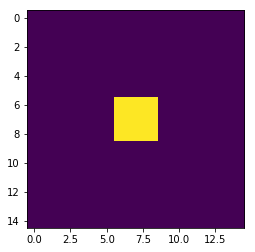

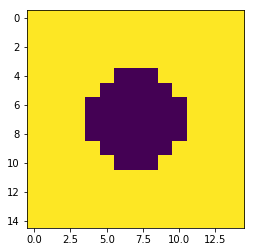

In [17]:
n = 7
x = np.linspace(-n, n, num=2*n+1)
y = np.linspace(-n, n, num=2*n+1)
x, y = np.meshgrid(x, y)

kernel_mean = (x**2+y**2 < 2**2)*1.0
kernel_bkg = (x**2 + y**2 > 3.5**2)*1.0

kernel_mean /= kernel_mean.sum()
kernel_bkg /= kernel_bkg.sum()

plt.imshow(kernel_mean)
plt.show()

plt.imshow(kernel_bkg)
plt.show()

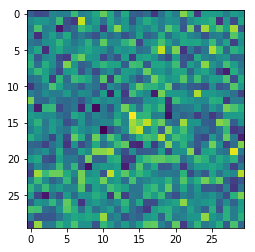

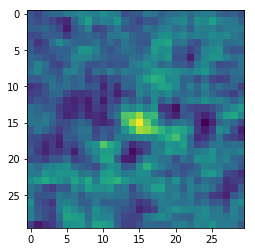

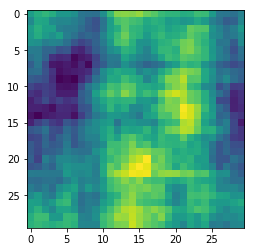

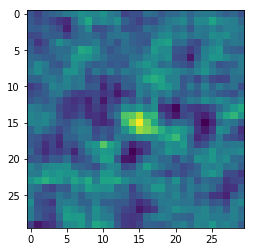

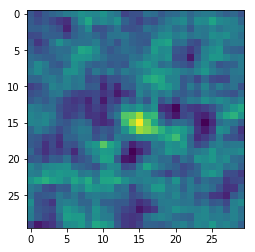

In [18]:
exact, noise = generate(30, 30,400, 200, 2, 7.0)

conv_mean = convolve2d(noise, kernel_mean, mode='same', boundary='wrap')
conv_bkg = convolve2d(noise, kernel_bkg, mode='same', boundary='wrap')

plt.imshow(noise)
plt.show()

plt.imshow(conv_mean)
plt.show()

plt.imshow(conv_bkg)
plt.show()

plt.imshow(conv_mean / conv_bkg)
plt.show()

plt.imshow(conv_mean - conv_bkg)
plt.show()

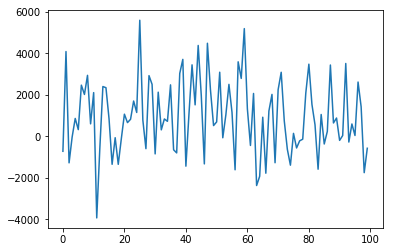

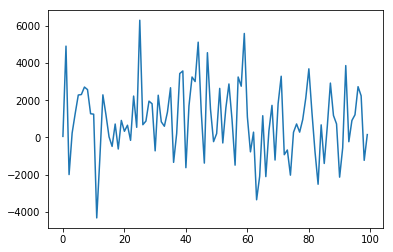

940.9668220332476
934.8984188991311
1780.6120517054255
1919.940055188722


In [20]:


N = 100

integral_mean = []
integral_median = []

for _ in range(N):
    exact, noise = generate(30, 30, 400, 100, 2, 7.0)
    
    r1 = 6
    r2 = 9
    r3 = 11
    
    integral_mean.append(integrate(noise, 15, 15, r1, r2, r3))
    integral_median.append(integrate_median(noise, 15, 15, r1, r2, r3))

plt.plot(integral_mean)
plt.show()

plt.plot(integral_median)
plt.show()


print(np.mean(integral_mean))
print(np.mean(integral_median))

print(np.std(integral_mean))
print(np.std(integral_median))

In [60]:
#result = least_squares(residual, initial_guess(noise))
scale = 7.0
bkg = 400

exact, noise = generate(30, 30, bkg, 100, 2, scale)
fit_height, fit_width = noise.shape

p = exact-400
p /= p.sum()

def residual(x):
    B, I = x
    M = noise - B - I*p
    var = scale*scale*M
    return (M**2 / var).flatten()


result = least_squares(residual, [300, 0])

print(result.x)
print((exact-bkg).sum())

[395.19504946 444.41946979]
1174.2575207417844


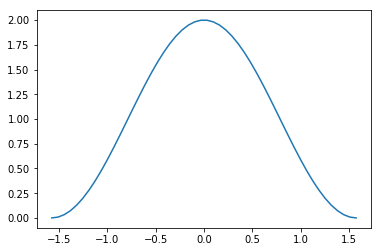

In [63]:
phi = np.linspace(-np.pi/2, np.pi/2)
mos = 1+np.cos(2*phi)

plt.plot(phi, mos)
plt.show()

0.0
0.0
-0.23564007183119495
0.0
0.4580090817468673
2.7755575615628914e-17
0.9718403966430852


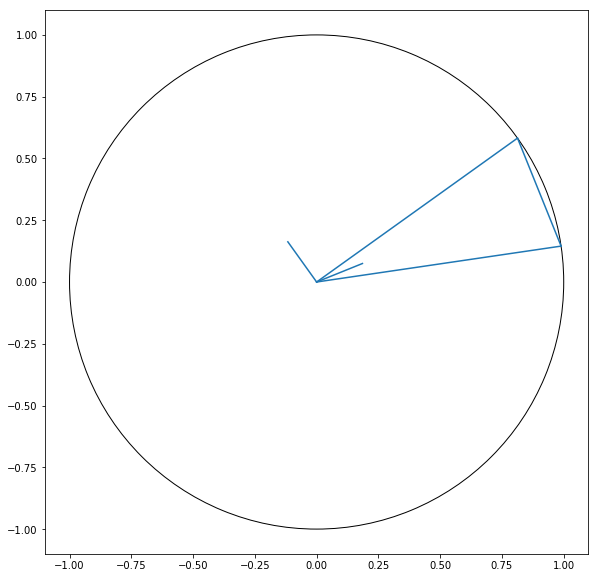

In [103]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Arc
from matplotlib.lines import Line2D

ki = np.array([np.random.rand(), np.random.rand(), 0])
ki /= np.linalg.norm(ki)

A = np.random.rand(2,2)
A = np.identity(2) + A.transpose().dot(A)
w, U = np.linalg.eig(A)

kf = U.dot(ki[:2])
kf = np.array([kf[0], kf[1], 0])
q = kf-ki

e1 = np.cross(kf, ki)
e1 /= np.linalg.norm(e1)
e2 = np.cross(kf, e1)
e2 /= np.linalg.norm(e2)
e3 = kf+ki
e3 /= np.linalg.norm(e3)

print(np.dot(e1, e2))
print(np.dot(e1, e3))
print(np.dot(e2, e3))
print(np.dot(q, e1))
print(np.dot(q, e2))
print(np.dot(q, e3))

A = np.array([e1, e2, e3])
print(np.linalg.det(A))

plt.figure(figsize=(10,10))
plt.axes()

circle = Arc((0, 0), 2, 2, 0, 0, 360)
plt.gca().add_patch(circle)

line = Line2D((0, ki[0]), (0, ki[1]))
plt.gca().add_line(line)

line = Line2D((0, kf[0]), (0, kf[1]))
plt.gca().add_line(line)

line = Line2D((ki[0], kf[0]), (ki[1], kf[1]))
plt.gca().add_line(line)

line = Line2D((0, 0.2*e2[0]), (0, 0.2*e2[1]))
plt.gca().add_line(line)

line = Line2D((0, 0.2*e3[0]), (0, 0.2*e3[1]))
plt.gca().add_line(line)

plt.axis('scaled')
plt.show()

In [ ]:
3